# Задание
1. Изучить пример, приведенный ниже.
2. Получить свой датасет у преподавателя.
3. Выбрать числовые признаки и таргет в датасете (признаки делаем числовыми или исключаем их).
2. Проанализировать результаты, полученные с помощью statsmodels.
3. Построить регрессионную зависимость (sklearn [тык](https://scikit-learn.ru/user_guide/)) с помощью метода наименьших квадратов, используя вычисление обратной матрицы. 
4. Построить регрессионную зависимость (sklearn) с помощью метода наименьших квадратов, используя метод градиентного спуска. 
4. Сравнить и описать результаты.

# Регрессионный анализ


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings("ignore")
%matplotlib inline

Немного о pandas

[Документация](https://pandas.pydata.org/docs/user_guide/index.html#user-guide) 

[Шпаргалка](https://smysl.io/blog/pandas/) 

[Еще немного](https://blog.skillfactory.ru/kak-nachat-analizirovat-dannye-v-pandas-pervye-shagi/)

[Работа с датой](https://habr.com/ru/company/wunderfund/blog/677068/)

In [2]:
df = pd.read_csv('hungary_chickenpox/hungary_chickenpox.csv')

In [3]:
print ("Total number of rows in dataset = {}".format(df.shape[0]))
print ("Total number of columns in dataset = {}".format(df.shape[1]))

Total number of rows in dataset = 522
Total number of columns in dataset = 21


In [4]:
df.head()

,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,...,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,03/01/2005,168,79,30,173,169,42,136,120,162,...,130,57,2,178,66,64,11,29,87,68
1,10/01/2005,157,60,30,92,200,53,51,70,84,...,80,50,29,141,48,29,58,53,68,26
2,17/01/2005,96,44,31,86,93,30,93,84,191,...,64,46,4,157,33,33,24,18,62,44
3,24/01/2005,163,49,43,126,46,39,52,114,107,...,63,54,14,107,66,50,25,21,43,31
4,31/01/2005,122,78,53,87,103,34,95,131,172,...,61,49,11,124,63,56,7,47,85,60


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      522 non-null    object
 1   BUDAPEST  522 non-null    int64 
 2   BARANYA   522 non-null    int64 
 3   BACS      522 non-null    int64 
 4   BEKES     522 non-null    int64 
 5   BORSOD    522 non-null    int64 
 6   CSONGRAD  522 non-null    int64 
 7   FEJER     522 non-null    int64 
 8   GYOR      522 non-null    int64 
 9   HAJDU     522 non-null    int64 
 10  HEVES     522 non-null    int64 
 11  JASZ      522 non-null    int64 
 12  KOMAROM   522 non-null    int64 
 13  NOGRAD    522 non-null    int64 
 14  PEST      522 non-null    int64 
 15  SOMOGY    522 non-null    int64 
 16  SZABOLCS  522 non-null    int64 
 17  TOLNA     522 non-null    int64 
 18  VAS       522 non-null    int64 
 19  VESZPREM  522 non-null    int64 
 20  ZALA      522 non-null    int64 
dtypes: int64(20), ob

In [6]:
df.nunique()

Date        522
BUDAPEST    217
BARANYA     114
BACS        120
BEKES       110
BORSOD      160
CSONGRAD    113
FEJER       110
GYOR        123
HAJDU       140
HEVES       105
JASZ        126
KOMAROM      86
NOGRAD       82
PEST        196
SOMOGY       96
SZABOLCS    104
TOLNA        83
VAS          90
VESZPREM    128
ZALA         80
dtype: int64

так как столебц Date униклен для каждого знаечния, нет смысла его оцифровывать, удаляем

In [7]:
del df['Date']

In [8]:
df.head()

,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,168,79,30,173,169,42,136,120,162,36,130,57,2,178,66,64,11,29,87,68
1,157,60,30,92,200,53,51,70,84,28,80,50,29,141,48,29,58,53,68,26
2,96,44,31,86,93,30,93,84,191,51,64,46,4,157,33,33,24,18,62,44
3,163,49,43,126,46,39,52,114,107,42,63,54,14,107,66,50,25,21,43,31
4,122,78,53,87,103,34,95,131,172,40,61,49,11,124,63,56,7,47,85,60


перебором понимаем, что резонне всего в качестве таргета выбрать столбец BUDAPEST

In [9]:
target_col = "BUDAPEST"

In [10]:
X = df.loc[:, df.columns != target_col]
y = df.loc[:, target_col]

In [11]:
# Split the data into train and test with 70% data being used for training
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state=42)


# Линейная регрессия (statsmodels)



In [12]:
X_with_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_with_constant)

In [13]:
results = model.fit()
results.params

const       9.213730
BARANYA    -0.246565
BACS        0.327657
BEKES       0.119765
BORSOD      0.332255
CSONGRAD    0.469223
FEJER       0.042097
GYOR       -0.051792
HAJDU       0.119162
HEVES      -0.138024
JASZ        0.167934
KOMAROM     0.069077
NOGRAD      0.293010
PEST        0.346812
SOMOGY      0.185068
SZABOLCS   -0.107770
TOLNA       0.535621
VAS        -0.108982
VESZPREM   -0.337542
ZALA        0.343327
dtype: float64

In [14]:
print(results.summary())

# R-squared > 0.7
# F-statistic != none and > 0
# Prob (F-statistic) < 0.05
# p>|t| -> should be < 0.05 else delete coloumn del df['bla-bla']

                            OLS Regression Results                            
Dep. Variable:               BUDAPEST   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     49.57
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           1.89e-86
Time:                        15:47:04   Log-Likelihood:                -1840.5
No. Observations:                 365   AIC:                             3721.
Df Residuals:                     345   BIC:                             3799.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.2137      3.609      2.553      0.0

1. Коэффициенты регрессии модели Y = b0 + b1∙d1 + b2∙d2 + b3∙d3:



> Intercept = b0 =  2.7089 

>b1 = 0.0441
>b2 = 0.1993
>b3 = 0.0069


2. Коэффициент детерминации R-squared = 0.906, его скорректированная оценка Adj. R-squared = 0.903 - это означает, что регрессионная модель объясняет 90% вариации переменной Y.


3. Проверка значимости коэффициента детерминации:

>расчетное значение статистики критерия Фишера: F-statistic = 434,5

>расчетный уровень значимости Prob (F-statistic) = 1.88e-69

>так как значение Prob (F-statistic) < 0.05, то нулевая гипотеза R-squared = 0 НЕ ПРИНИМАЕТСЯ, т.е. коэффициент детерминации ЗНАЧИМ

4. Проверка значимости коэффициентов регрессии:

>расчетный уровень значимости P>|t| для b0, b1, b2 не превышает 0.05 - это означает, что коэффициенты регрессии значимы

>об этом же свидетельствует то, что доверительный интервал для коэффициентов регрессии ([0.025; 0.975]) не включает в себя точку 0

>расчетный уровень значимости P>|t| для b3 превышает 0.05. Нулевая гипотеза не отвергается. b3 не является значимым.
Нулевая гипотеза - коэффициет равен нулю, альтернативная - не равен.

5. значение t для b3 очень мало (чем выше значение t, тем выше шанс, что мы отвергаем нулевую гипотезу).

Также в таблице результатов содержится прочая информация по коэффициентам регрессии: стандартная ошибка Std.Err. 

# Ваше задание
Удаляем признаки, которые не являются значимыми, и повторяем обучение без них.

In [15]:
del df['BEKES']
del df['FEJER']
del df['GYOR']
del df['HAJDU']
del df['HEVES']
del df['JASZ'] 
del df['KOMAROM'] 
del df['SOMOGY'] 
del df['SZABOLCS'] 
del df['VAS']

In [16]:
X = df.loc[:, df.columns != target_col]
y = df.loc[:, target_col]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state=42)

In [18]:
X_with_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_with_constant)

In [19]:
results = model.fit()
results.params

const       10.702614
BARANYA     -0.161809
BACS         0.368089
BORSOD       0.364904
CSONGRAD     0.442352
NOGRAD       0.202205
PEST         0.371866
TOLNA        0.581142
VESZPREM    -0.249465
ZALA         0.370405
dtype: float64

In [20]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               BUDAPEST   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     101.4
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           1.72e-92
Time:                        15:47:04   Log-Likelihood:                -1848.5
No. Observations:                 365   AIC:                             3717.
Df Residuals:                     355   BIC:                             3756.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7026      3.544      3.020      0.0

видим, что некоторые значения поменялись, удаляем новые незначимые столбцы, повторяем обучение

In [21]:
del df['BARANYA']
del df['NOGRAD']

del df['PEST']

del df['VESZPREM']

In [22]:
X = df.loc[:, df.columns != target_col]
y = df.loc[:, target_col]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state=42)

In [24]:
X_with_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_with_constant)

In [25]:
results = model.fit()
results.params

const       16.209821
BACS         0.480192
BORSOD       0.477930
CSONGRAD     0.473726
TOLNA        0.768074
ZALA         0.389275
dtype: float64

In [26]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               BUDAPEST   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     151.6
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           3.36e-86
Time:                        15:47:04   Log-Likelihood:                -1873.6
No. Observations:                 365   AIC:                             3759.
Df Residuals:                     359   BIC:                             3783.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.2098      3.663      4.426      0.0

In [27]:
X_test = sm.add_constant(X_test)
y_pred = results.predict(X_test)
residual = y_test - y_pred

# Предпосылки линейной регрессии
Модель линейной регрессии можно построить не для любых данных, а только для данных, которые удовлетворяют ряду условий. И прежде, чем использовать регрессионное уравнение для прогнозирования, необходимо проверить выполнение этих условий. В ином случае наша модель не будет адекватна поставленной задаче, и ее использование будет бессмысленно.

# Наличие линейной зависимости
Первая и самая естественная предпосылка заключается в линейности модели. Под этим условием подразумевается корректность модели, выбор адекватных предикторов и отсутствие лишних предикторов. А также линейную зависимость целевой переменной от независимых переменных.

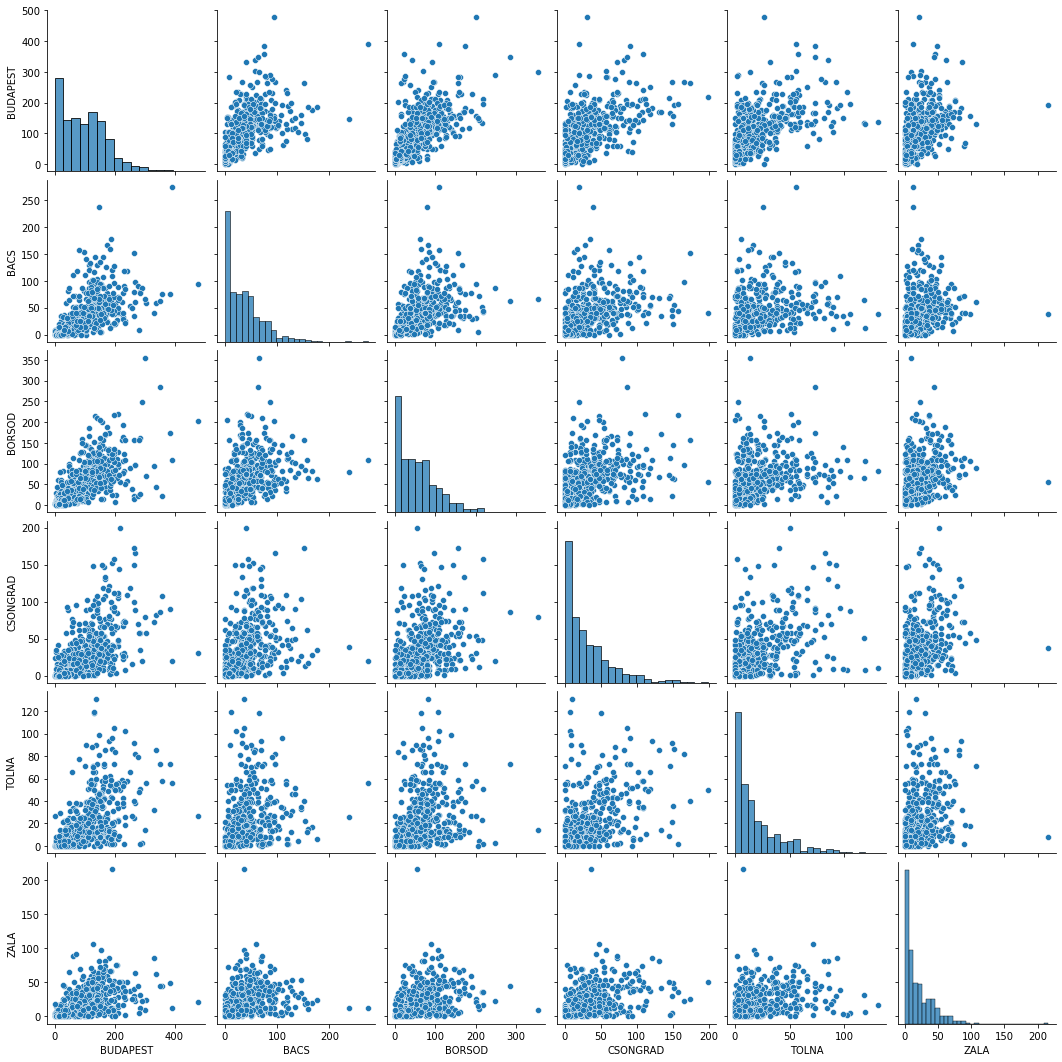

In [28]:
sns.pairplot(df)

# Отсутствие мультиколлинеарности

Мультиколлинеарностью называют явление, которое заключается в наличии линейной зависимости между независимыми переменными (предикторами). Такое может возникать, например, при использовании признаков с естественной взаимосвязью: стаж работы и возраст (как правило, чем больше возраст - тем больше стаж и наоборот), количество детских садов и количество школ в районе (обычно детские сады бывают при школе, так что эти количества пропорционально взаимосвязаны) или баллы за экзамены IELTS и TOEFL (так как они экзамены проверяют примерно одни и те же знания и навыки)

Последствием мультиколлинеарности является расширение доверительных интервалов для коэффициентов, и модель получается очень неустойчивой и меняющейся от добавления даже 1-2 новых наблюдений. Разумеется, это не очень хорошая для нас ситуация, поэтому мы должны отбирать для модели только те предикторы, между которыми нет линейной связи.

Для того чтобы проверить данную предпосылку, нам необходимо построить матрицу корреляций для всех потенциальных предикторов, и отследить наличие сильной корреляционной связи. Нет четкой границы, которая отделяет допустимую взаимосвязь и недопустимую, но в ряде источников используется граница в районе 0.9. То есть, если между предикторами коэффициент корреляции по модулю больше, чем 0.9, то мы не можем оба этих предиктора использовать для модели.

Почитать:

[wiki](https://ru.wikipedia.org/wiki/%D0%9C%D1%83%D0%BB%D1%8C%D1%82%D0%B8%D0%BA%D0%BE%D0%BB%D0%BB%D0%B8%D0%BD%D0%B5%D0%B0%D1%80%D0%BD%D0%BE%D1%81%D1%82%D1%8C#:~:text=%D0%9C%D1%83%D0%BB%D1%8C%D1%82%D0%B8%D0%BA%D0%BE%D0%BB%D0%BB%D0%B8%D0%BD%D0%B5%D0%B0%D1%80%D0%BD%D0%BE%D1%81%D1%82%D1%8C%20(multicollinearity)%20%E2%80%94%20%D0%B2%20%D1%8D%D0%BA%D0%BE%D0%BD%D0%BE%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%BA%D0%B5,%D0%BD%D0%B0%D0%BB%D0%B8%D1%87%D0%B8%D0%B5%20%D1%81%D0%B8%D0%BB%D1%8C%D0%BD%D0%BE%D0%B9%20%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D0%B8%20%D0%BC%D0%B5%D0%B6%D0%B4%D1%83%20%D1%84%D0%B0%D0%BA%D1%82%D0%BE%D1%80%D0%B0%D0%BC%D0%B8)

[статья](https://towardsdatascience.com/why-multicollinearity-isnt-an-issue-in-machine-learning-5c9aa2f1a83a)


In [29]:
df_1 = df.copy()

del df_1[target_col]

cols_num = df_1.columns

correlation = df_1.corr().loc[cols_num, cols_num]
correlation

,BACS,BORSOD,CSONGRAD,TOLNA,ZALA
BACS,1.000000,0.497418,0.410252,0.354881,0.338640
BORSOD,0.497418,1.000000,0.450051,0.354870,0.403490
CSONGRAD,0.410252,0.450051,1.000000,0.463611,0.432991
TOLNA,0.354881,0.354870,0.463611,1.000000,0.353683
ZALA,0.338640,0.403490,0.432991,0.353683,1.000000


<AxesSubplot:>

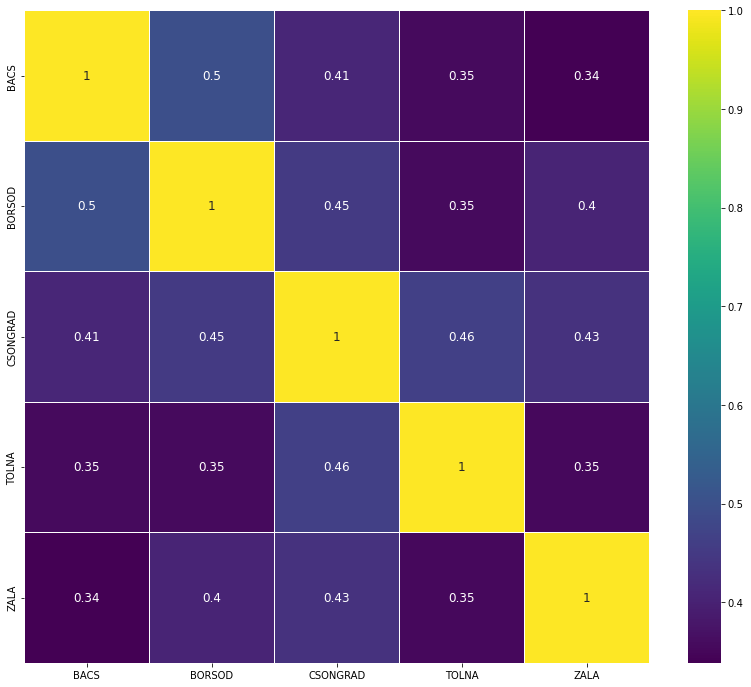

In [30]:
fig , ax = plt.subplots(figsize = (14,12))

sns.heatmap(correlation, 
            linewidths=0.5, annot=True,cmap='viridis',
            linecolor="white", annot_kws = {'size':12})

Фактор инфляции дисперсии

vif > 10 - выраженная мультиколлинеарность

In [31]:
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X_train.columns).T

,BACS,BORSOD,CSONGRAD,TOLNA,ZALA
vif,2.661996,3.154693,2.888655,2.350755,2.277998


# Нормальное распределение ошибок
После того как мы построили модель регрессии, мы можем вычислить ошибки (остатки): разницы между реальным значением $y$ и предсказанным $\hat{y}$. Важным условием является нормальность распределения этих ошибок. То есть, распределение остатков должно стремиться к нормальному распределению. Проверить выполняемость этого условия можно визуально с помощью гистограммы или с помощью специальных статистических тестов.

В целом, такое условие связано не напрямую с остатками, а с тем, что зависимая переменная должна быть распределена нормально для любых значений х. Однако такое условие проверить довольно сложно, поэтому можно проверить такое условие с помощью анализа распределения остатков.

<AxesSubplot:ylabel='Density'>

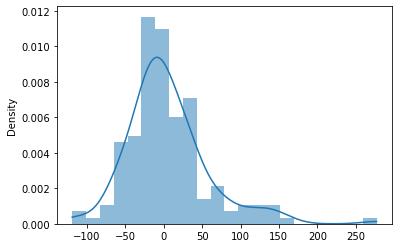

In [32]:
sns.histplot(residual, kde=True, stat="density", linewidth=0)

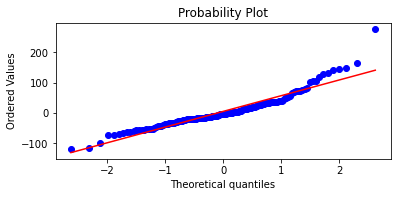

In [33]:
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

In [34]:
np.mean(residual)

5.39113583808409

# Гомоскедастичность 
Гомоскедастичность ошибок заключается в том, что разброс остатков при любых значениях независимых переменных одинаковый. 

Если предположение о гомоскедастичности нарушается, т.е. имеет место гетероскедастичность, это может затруднить интерпретацию результатов регрессии, поскольку в этом случае значение выходной переменной зависит не только от величины изменения входной, но и от того, относительно какой величины это изменение происходит.

Например, если использовать при построении регрессионной модели данные о доходе клиентов, то попытка применить одну модель для богатых и бедных может вызвать проблемы. Действительно, если изменение суммы дохода на 1 000 руб. окажется значимым для клиента с доходом 10 000 руб., то для клиента с доходом 1 000 000 руб. это не так. А регрессионная модель, тем не менее, применяет к ним одну и ту же закономерность. Чтобы этого не произошло, клиентов с низкими и высокими доходами следует разбить на две выборки и таким образом обеспечить гомоскедастичность.

[wiki](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D0%BC%D0%BE%D1%81%D0%BA%D0%B5%D0%B4%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%BE%D1%81%D1%82%D1%8C)

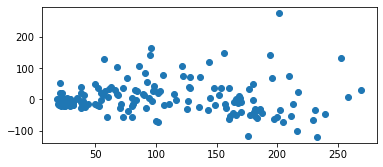

In [35]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, residual)

# Отсутствие автокорреляции остатков
Автокорреляция остатков (ошибок) возникает в ситуации, когда есть линейная взаимосвязь между остатками для одних значений предикторов и остатками для других значений предикторов. Такое может проявляться в силу естественных причин, как и в случае с мультиколлинеарностью. Например, если мы предсказываем какие-то показатели для соседних регионов страны, то, скорее всего, они будут сильно взаимосвязаны просто в силу схожести характеристик этих объектов.

Автокорреляция влечет за собой некорректные результаты. Стандартные ошибки получаются несостоятельными, и мы не можем строить корректные доверительные интервалы и проверять гипотезы классическими способами.

[wiki](https://ru.wikipedia.org/wiki/%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F)

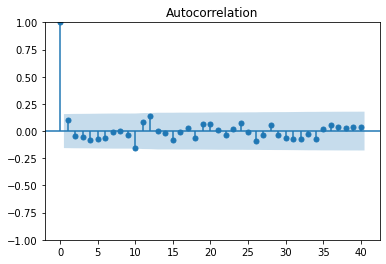

In [36]:
acf = smt.graphics.plot_acf(residual, lags=40 , alpha=0.05)
acf.show()


## Матрицами 

$\beta^* = (X^T \cdot X)^{-1}\cdot X^T \cdot Y$



In [37]:
# тут будет код
from numpy.linalg import inv

b = inv(X_with_constant.T.dot(X_with_constant)).dot(X_with_constant.T).dot(y_train)
print(b)

[16.20982065  0.48019193  0.47792969  0.47372559  0.76807428  0.38927531]


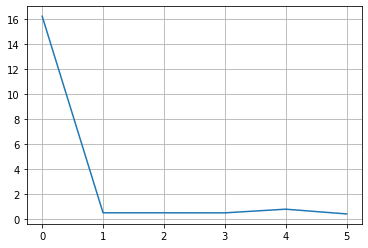

In [38]:
#график
fig, ax = plt.subplots()
ax.plot(b)
plt.grid()

## Градиентным спуском

$x^{(i)}$ - вектор-столбец всех значений признаков i-го обучающего примера;<br>
$x_j^{(i)}$ - значение j-го признака i-го обучающего примера;<br>
$x_j$ - вектор j-го признака всех обучающих примеров;<br>
$m$ - количество примеров в обучающей выборке;<br>
$n$ - количество признаков;<br>
$X$ - матрица признаков;<br>
$b$ - вектор параметров регрессии;<br>
${\alpha}$ - скорость обучения

Общий вид модели множественной линейной регрессии:
$$h_b(x) = b_0 + b_1 x_1 + b_2 x_2 + ... + b_n x_n$$<br>
Или в матричной форме:<br>
$$h_b(x) = X \cdot \vec{b}$$<br>
Используя определение матричного умножения, наша многопараметрическая функция гипотезы может быть кратко представлена в виде: $h(x) = B X$

Теперь, когда мы знаем виды функции гипотезы, то есть нашей модели, мы можем переходить к следующему шагу: функции ошибки.<br>
Для множественной регрессии функция ошибки от вектора параметров b выглядит следующим образом:
$$J(b) = \frac{1}{2m} \sum_{i=1}^{m} (h_b(x^{(i)}) - y^{(i)})^2$$<br>
Или в матричной форме:
$$J(b) = \frac{1}{2m} (X b - \vec{y})^T (X b - \vec{y})$$<br>
Мы специально не раскрываем выражение $h_b(x^{(i)})$. Это нужно, чтобы подчеркнуть, что форма функции ошибки не зависит от функции гипотезы, она выражается через нее.

Теперь нам нужно взять производную этой функции ошибки (градиент).
$$\frac{\partial}{\partial b_i} J = 
\frac{1}{m} \sum_{i=1}^{m} (h_b(x^{(i)}) - y^{(i)}) \cdot \frac{\partial}{\partial b_i} h_b(x^{(i)})$$<br>
В такой формулировке мы представляем частные производные функции ошибки (градиент) через частную производную функции гипотезы. Это так называемое моделенезависимое представление градиента. Ведь для этой формулы совершенно неважно, какой функцией будет наша гипотеза. Пока она является дифференцируемой, мы можем использовать градиент ее функции ошибки. 

Метод градиентного спуска для множественной регрессии определяется следующими уравнениями:
$$b_0 := b_0 - \alpha \frac{1}{m} \sum_{i=1}^{m} (h_b(x^{(i)}) - y^{(i)}) \cdot x_0^{(i)}$$
$$b_1 := b_1 - \alpha \frac{1}{m} \sum_{i=1}^{m} (h_b(x^{(i)}) - y^{(i)}) \cdot x_1^{(i)}$$
$$b_2 := b_2 - \alpha \frac{1}{m} \sum_{i=1}^{m} (h_b(x^{(i)}) - y^{(i)}) \cdot x_2^{(i)}$$<br>
Или в матричной форме:
$$b := b - \frac{\alpha}{m} X^T (X b - \vec{y})$$

In [39]:
m, n = np.shape(X_with_constant)
print(m)
print(n)

n = np.ones(n)
print(n)

365
6
[1. 1. 1. 1. 1. 1.]


In [40]:
#находит стоимость с помощью линейной регрессии
def computeCost(X, y, theta):
    m = y.shape[0] # m = 522
    J = sum(((X.dot(theta)) - y) ** 2) / (2 * m) #функция ошибки от вектора параметров b
    return(J)

In [41]:
#вычисляет градиентный спуск за num_iters итераций, чтобы определить низкую стоимость(cost)
def gradientDescent(X, y, theta, alpha, num_iters):
    m = y.shape[0]  #количество обучающих примеров 522
#     J_history = [] # тут будет храниться история каждой итерации

    for i in range(num_iters):
        hyp = np.dot(X, theta) #множественая линейная регрессия
        
        #градиентный спуск для множественной регрессии
        temp = hyp - y
        temp_two = np.dot(X.T, temp)        
        theta = theta - ((alpha / m) * temp_two)        
        
        #выводим каждую итерацию
#         print(i, " - ", computeCost(X, y, theta))

    return theta

In [42]:
alpha = 0.0001
num_iters = 80000

In [43]:
thet = gradientDescent(X_with_constant, y_train, n, alpha, num_iters)

In [44]:
print(*thet, sep="\n", end="\n\n") 

15.280722886490839
0.48349987394175314
0.48225763153611895
0.47637492044294777
0.7722005346532806
0.39354415987550156



https://koroteev.site/text/ml1/?ysclid=la7bo1tfda80743003

# Линейная регрессия sklearn

In [45]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()
regr.fit(X_with_constant, y_train)

y_pred = regr.predict(X_with_constant)

cef = regr.coef_
print("Coefficients: \n", cef)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_train, y_pred))

Coefficients: 
 [0.         0.48019193 0.47792969 0.47372559 0.76807428 0.38927531]
Mean squared error: 1683.28
Coefficient of determination: 0.68


# Тут будет описание

Проанализировал базу данных, после анализа выяснил, что оцифровка не требуется, нашелся один столбец, который не имел смылсла в дальнейших вычислениях из-за чего был удален.<br>

Перебором выяснил, что наилуший столбец в качестве таргета будет выступать столбец  BUDAPEST. Обучил модель. После проверки таблицы "OLS Regression Results" обнаружил столбцы, которые не являются значимыми, удалил их и обучил модель еще раз, обнаружил, что значения изменились и выявились новые незначимые столбцы, удалил их и обучил модель еще раз, псоле чего все столбцы были значимые. Столбец PEST также был удален по причине сильной корреляции (> 0.6).<br>

После всех манипуляций над данными проверил их на гомоскедастичность и отсутствие автокорреляционных остатков.<br>
После проверок нашел коэффициенты регрессии с помощью  матричного метода, метода градиентного спуска и линейной регрессии. Ниже сравнение коэффициентов.

In [46]:
statsmodels_arr = np.array(results.params)
b_arr = np.array(b)
thet_arr = np.array(thet) 
coef_arr = np.array(cef)

In [47]:
data = {'b(matrix)' : [i for i in b_arr],
       'Gradient Descent' : [i for i in thet_arr],
       'Linear Regression' : [i for i in coef_arr],
       'statsmodels' : [i for i in statsmodels_arr]}

comparison = pd.DataFrame(data = data)
comparison.index = ['b0', 'b1','b2','b3','b4', 'b5']
comparison

,b(matrix),Gradient Descent,Linear Regression,statsmodels
b0,16.209821,15.280723,0.000000,16.209821
b1,0.480192,0.483500,0.480192,0.480192
b2,0.477930,0.482258,0.477930,0.477930
b3,0.473726,0.476375,0.473726,0.473726
b4,0.768074,0.772201,0.768074,0.768074
b5,0.389275,0.393544,0.389275,0.389275


# По материалам
1. https://github.com/bhattbhavesh91/linear-regression-assumptions
2. https://towardsdatascience.com/assumptions-of-linear-regression-fdb71ebeaa8b
3. https://habr.com/en/post/690414/
4. Еще каких-то хороших людей